Importing relevant libraries:

In [315]:
import sys
import numpy
import scipy
import sklearn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import skorch

from sklearn import preprocessing

Importing data:

In [319]:
test_data = pd.read_csv('Tugba Sanver-test_notebook_file.csv')
test_data

FileNotFoundError: [Errno 2] No such file or directory: 'Tugba Sanver-test_notebook_file.csv'

In [281]:
print("Shape of the Data: ", test_data.shape )

Shape of the Data:  (346, 7)


In [282]:
y_test = test_data.values[:,-1].copy()
X_test = test_data.values[:,:-1].copy()

Encoding data into numerical:

In [283]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

onehotencoder = OneHotEncoder()
X_test = onehotencoder.fit_transform(X_test).toarray()
labelencoder = LabelEncoder()
y_test = labelencoder.fit_transform(y_test)

In [284]:
from collections import Counter
print(sorted(Counter(y_test).items()))

[(0, 59), (1, 14), (2, 260), (3, 13)]


# MLP

Importing Skorch library:

In [285]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from skorch.callbacks import EpochScoring

In [286]:
import torch.nn as nn
import torch.nn.functional as F
device = 'cpu'

In [287]:
X_test_torch = torch.FloatTensor(X_test)
y_test_torch = torch.LongTensor(y_test)


In [321]:
input_sz = X_test_torch.shape[1]
hidden_sz = input_sz
output_sz = y_test_torch.max().item()+1
print('input size: %d, hidden size: %d, output size: %d'%(input_sz,hidden_sz, output_sz))

input size: 21, hidden size: 21, output size: 4


In [288]:
class CarClassificationNN(nn.Module): #reference: lab 5
    
    def __init__(
            self,
            input_dim=input_sz,
            hidden_dim=hidden_sz,
            output_dim=output_sz,
            dropout=0.5,
    ):
        super(CarClassificationNN, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.tanh(self.hidden(x)) 
        x = self.dropout(x)
        x = F.softmax(self.output(x), dim=-1)
        return x

I load the saved MLP model via pickle library:

In [289]:
import pickle
with open('mlp_model.pkl', 'rb') as f:
    net_final = pickle.load(f)
net_final.initialize()
net_final.load_params(
    f_params='model.pkl', f_optimizer='opt.pkl', f_history='history.json')

In [290]:
net_final

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CarClassificationNN(
    (dropout): Dropout(p=0.5, inplace=False)
    (hidden): Linear(in_features=21, out_features=21, bias=True)
    (output): Linear(in_features=21, out_features=4, bias=True)
  ),
)

In [291]:
net_final.fit(X_test_torch, y_test_torch)

Re-initializing module.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3556       0.7429        1.0942  0.0080
      2        1.0386       0.7429        0.8855  0.0090
      3        0.8652       0.7429        0.7777  0.0090
      4        0.7476       0.7429        0.7360  0.0070
      5        0.7052       0.7429        0.7111  0.0090
      6        0.6974       0.7429        0.6835  0.0100
      7        0.6571       0.7857        0.6552  0.0070
      8        0.6061       0.8000        0.6255  0.0070
      9        0.5884       0.8000        0.5903  0.0110
     10        0.5650       0.8000        0.5514  0.0110
     11        0.5190       0.8000        0.5160  0.0090
     12        0.4782       0.8000        0.4872  0.0070
     13        0.4468       0.8000        0.4641  0.0120
     14        0.4107       0.8143        0.4446  0.0080
     15        0.3904       0.8143   

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CarClassificationNN(
    (dropout): Dropout(p=0.5, inplace=False)
    (hidden): Linear(in_features=21, out_features=21, bias=True)
    (output): Linear(in_features=21, out_features=4, bias=True)
  ),
)

Importing metrics:

In [292]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import svm, metrics

Classification report:

In [293]:
y_pred = net_final.predict(X_test_torch)
print(classification_report(y_test_torch, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        59
           1       0.77      0.71      0.74        14
           2       0.97      0.98      0.97       260
           3       0.77      0.77      0.77        13

    accuracy                           0.93       346
   macro avg       0.84      0.82      0.83       346
weighted avg       0.93      0.93      0.93       346



Confusion matrix:

Text(0.5, 0.98, '')

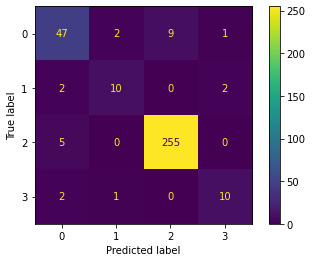

In [294]:
disp = metrics.plot_confusion_matrix(net_final, X_test_torch, y_test_torch)

disp.figure_.suptitle('')

Estimation accuracy plot:

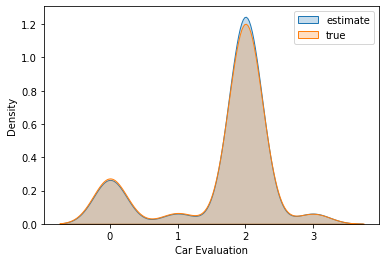

In [295]:
sns.kdeplot(y_pred, label='estimate', shade=True)
sns.kdeplot(y_test_torch, label='true', shade=True)
plt.xlabel('Car Evaluation')
plt.legend()

In [296]:
pred_prob = net_final.predict_proba(X_test_torch)

### ROC-AUC curve:

Importing relevant libraries and tools:

In [297]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

Then we calculate true positive and false positive rates from roc_curve tool:

In [298]:
%matplotlib inline
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_classes = 4

for i in range(n_classes):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(roc_auc[i])

0.9816334967223764
0.9931153184165232
0.9949910554561718
0.9884499884499884


Then we plot the ROC curve using some multiclass to binary adjustment:

<ipython-input-301-9b9712b8a8d3>:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


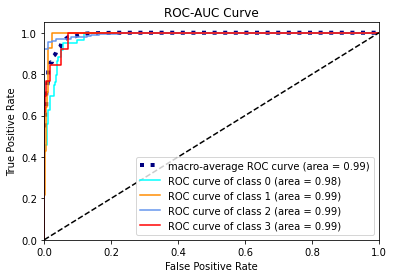

In [301]:
#Code reference:https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()

Looks like our True Positive Rate are high for all classes. It means our classifier predicted classes mostly correct.

# SVM

Loading SVM model with pickle:

In [303]:
with open('svm_model.pkl', 'rb') as f:
    svm_model = pickle.load(f)

In [304]:
svm_model

OneVsRestClassifier(estimator=SVC(C=1, gamma=0.5, kernel='poly',
                                  probability=True))

Making prediction:

In [305]:
y_pred_svm = svm_model.predict(X_test)


Classification report:

In [306]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        59
           1       1.00      1.00      1.00        14
           2       1.00      0.99      0.99       260
           3       1.00      1.00      1.00        13

    accuracy                           0.99       346
   macro avg       0.99      1.00      0.99       346
weighted avg       0.99      0.99      0.99       346



Confusion matrix for SVM:

Text(0.5, 0.98, '')

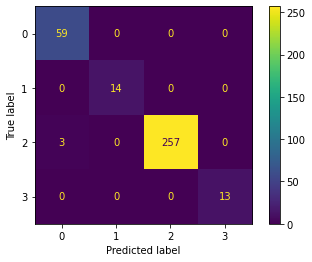

In [307]:
disp = metrics.plot_confusion_matrix(svm_model, X_test, y_test)

disp.figure_.suptitle('')

Estimation accuracy plot for SVM:

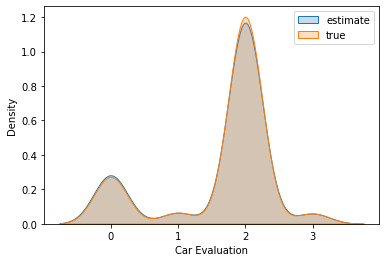

In [308]:
sns.kdeplot(y_pred_svm, label='estimate', shade=True)
sns.kdeplot(y_test, label='true', shade=True)
plt.xlabel('Car Evaluation')
plt.legend()

In [309]:
pred = svm_model.predict(X_test)
pred_prob = svm_model.predict_proba(X_test)
pred_prob

array([[3.63745227e-06, 6.81318958e-04, 9.99314058e-01, 9.85713189e-07],
       [9.99460366e-01, 2.79536282e-05, 5.11224051e-04, 4.56465162e-07],
       [7.42248336e-04, 2.32481604e-06, 9.99255211e-01, 2.16271647e-07],
       ...,
       [9.83580940e-04, 9.99019333e-08, 9.99016059e-01, 2.60284213e-07],
       [1.20417229e-05, 6.73195075e-06, 9.99980461e-01, 7.65044292e-07],
       [1.36767315e-05, 7.39317479e-06, 9.99978449e-01, 4.81253925e-07]])

### ROC-AUC curve:

In [310]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

In [311]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_classes = 4

for i in range(n_classes):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(roc_auc[i])

1.0
1.0
1.0
1.0


<ipython-input-313-d18502488faa>:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


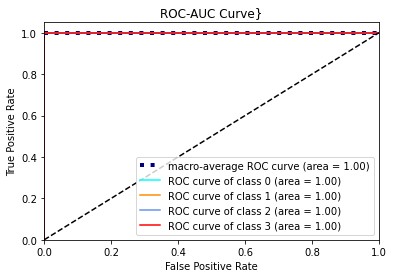

In [313]:
#Reference:https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve}')
plt.legend(loc="lower right")
plt.show()

Looks like our True Positive Rate are almost 1 for all classes. It means our classifier predicted classes mostly correct.